Takes in .AWD, sleep log if it exists, calendar, and spits out some pretty pictures

In [2]:
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, '/data/MoodGroup/actigraphy/gavi/actigraPy') 

import actigraPy.actigraPy as act
import importlib
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta

/data/MoodGroup/actigraphy/gavi/actigraPy/actigraPy/actigraPy.py:23: MatplotlibDeprecationWarning: 
The matplotlib.backends.tkagg module was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  import matplotlib.backends.tkagg as tkagg


## Subject and directory info

In [10]:
# data and log directories
sub = '135' #subject NUMBER as STRING
sub_long = 'sub-MOA'+sub

out_dir = '/data/MoodGroup/actigraphy/KMOA/derivatives/preproc/'+sub_long #output directory
data_dir = '/data/MoodGroup/actigraphy/KMOA/raw/' + sub_long

if not os.path.exists(out_dir):
    os.mkdir(out_dir)


In [14]:
fn = {}
#.AWD
awd_fn = os.path.join(data_dir, sub_long+'_0.AWD')
#sleeplog
fn['cal']= os.path.join(data_dir, sub_long + '_calendar_log.xls')
#calendar
fn['log'] = os.path.join(data_dir, sub_long+'_sleeplog.xls')
logs = []
Mtimes_fn = os.path.join(out_dir,sub_long+'_Mtimes_edit.csv')

if os.path.isfile(awd_fn):
    for name in fn.keys():
        if os.path.isfile(fn[name]):
            print("%s has %s file at %s"%(sub,name,fn[name]))
            logs.append(fn[name])
        else:
            print("no " + name)
            fn[name] = ''
else:
    print("DO NOT CONTINUE!! THERE IS NO AWD FILE")

135 has cal file at /data/MoodGroup/actigraphy/KMOA/raw/sub-MOA135/sub-MOA135_calendar_log.xls
135 has log file at /data/MoodGroup/actigraphy/KMOA/raw/sub-MOA135/sub-MOA135_sleeplog.xls


In [13]:
fn['cal']

''

### Read Mtimes file

Figure out where to clip awd file

In [37]:
#read AWD file
awd_dat = act.read_AWD(awd_fn)
idx={'start':[0],'end':[len(awd_dat['dt_list'])-1]}
#get the start and stops from each log if they exist
for log in logs:
    log_dat, kw_dat, comments = act.read_log(log,awd_dat)
    
    if 'watch_on' in kw_dat.keys():
        on_date = kw_dat['watch_on'].iloc[0]['OnDate']
        on_time = kw_dat['watch_on'].iloc[0]['OnTime']
        on = datetime(on_date.year,on_date.month,on_date.day,on_time.hour,on_time.minute)
        #check if that time is in dt_list:
        if awd_dat['dt_list'].count(on) > 0:
            on_idx=awd_dat['dt_list'].index(on)
            idx['start'].append(on_idx)

    if 'watch_off' in kw_dat.keys():
        off_date = kw_dat['watch_off'].iloc[0]['OffDate']
        off_time = kw_dat['watch_off'].iloc[0]['OffTime']
        off = datetime(off_date.year,off_date.month,off_date.day,off_time.hour,off_time.minute)
        if awd_dat['dt_list'].count(off) > 0:
            off_idx=awd_dat['dt_list'].index(off)
            idx['end'].append(off_idx)
 
idx

      OffDate   OffTime     OnDate    OnTime      Comment  Unnamed: 5  \
0         NaT       NaN 2016-02-08  10:00:00        start         NaN   
1  2016-02-08  13:00:00 2016-02-08  14:30:00           3T         NaN   
2  2016-02-08  21:30:00 2016-02-09  07:00:00  Sleep study         NaN   
3  2016-02-09  14:00:00 2016-02-09  16:00:00           7T         NaN   
4  2016-02-10  10:00:00 2016-02-10  12:00:00          MEG         NaN   
5  2016-02-10  21:30:00 2016-02-11  07:00:00  Sleep study         NaN   
6  2016-02-11  09:00:00 2016-02-11  09:40:00     Infusion         NaN   
7  2016-02-11  15:00:00 2016-02-11  17:00:00          MEG         NaN   
8  2016-02-11  21:30:00 2016-02-12  07:00:00  Sleep study         NaN   
9  2016-02-12  08:00:00 2016-02-12  10:00:00           7T         NaN   
10 2016-02-13  10:00:00 2016-02-13  11:30:00           3T         NaN   
11 2016-02-21  10:00:00 2016-02-21  12:00:00           7T         NaN   
12 2016-02-22  13:00:00 2016-02-22  14:30:00       

{'start': [0, 144], 'end': [45947, 45283, 44479]}

## <font color='red'>This part needs user input! Use your judgment to decide which starts and ends from above to go with</font>


In [38]:
start = max(idx['start'])
end = min(idx['end'])
print('start = %d, end = %d'%(start,end))

start = 144, end = 44479


In [39]:
#modify these according to output from above!!
start =0
end = 45283
lim = [awd_dat['DateTime'][start],awd_dat['DateTime'][end]]
clip_dat = act.clip_dat(lim,awd_dat)

Now just run these cells in order to extract comments and write Mtimes

In [40]:
awd_dat=clip_dat
Mtimes = pd.read_csv(Mtimes_fn)
Mtimes['Off_dt'] = [datetime.strptime(x,'%d-%b-%y %I:%M %p') for x in Mtimes['OffDate']+" "+Mtimes['OffTime']]
Mtimes['On_dt'] = [datetime.strptime(x,'%d-%b-%y %I:%M %p') for x in Mtimes['OnDate']+" "+Mtimes['OnTime']]

umks = np.unique(Mtimes['marker'])
mk_idx={}
mc_dict={}
test={}
for mm in umks:
    print(mm)
    c_dict = {}
    tmp = Mtimes['Off_dt'][Mtimes['marker']==mm].tolist()
    tmp.extend(Mtimes['On_dt'][Mtimes['marker']==mm].tolist())
    tmp.sort()
    test[mm]=tmp
    mk_idx[mm] = [np.where(np.asarray(awd_dat['dt_list'])==x)[0][0] for x in tmp]
    
    
    if len((Mtimes['Comment'][Mtimes['marker']==mm]).dropna()) > 0:
        c_dict['comments']=Mtimes['Comment'].loc[(Mtimes['Comment'][Mtimes['marker']==mm]).dropna().index].tolist()
        tmp = Mtimes['Off_dt'].loc[(Mtimes['Comment'][Mtimes['marker']==mm]).dropna().index].tolist()
        c_dict['idxs']=[np.where(np.asarray(awd_dat['dt_list'])==x)[0].tolist()[0] for x in tmp]
        mc_dict[mm]=c_dict

M
cal
log
m
z


In [41]:
importlib.reload(act)
mk_idx,mc_dict=act.read_Mtimes(Mtimes_fn,clip_dat)

M
cal
log
m
z


In [253]:
act.write_dat(clip_dat,mk_idx,'/data/MoodGroup/actigraphy/KMOA/derivatives/preproc/subMOA-%s/%s'%(sub,sub))

,DateTime,activity,M,cal,g,log,z
0,08-Feb-16 03:40 PM,81,,0,0,0,0
1,08-Feb-16 03:41 PM,0,,0,0,0,0
2,08-Feb-16 03:42 PM,35,,0,0,0,0
3,08-Feb-16 03:43 PM,170,,0,0,0,0
4,08-Feb-16 03:44 PM,351,,0,0,0,0
5,08-Feb-16 03:45 PM,755,,0,0,0,0
6,08-Feb-16 03:46 PM,222,,0,0,0,0
7,08-Feb-16 03:47 PM,194,,0,0,0,0
8,08-Feb-16 03:48 PM,159,,0,0,0,0
9,08-Feb-16 03:49 PM,0,,0,0,0,0


## Make graphs

In [254]:
keys=['g'] #INPUT HERE WHICH KEYS YOU WANT

coms=[]
idxs=[]
for mm in keys:
    idxs.append(mc_dict[mm]['idxs'])
    coms.append(mc_dict[mm]['comments'])
gc=[np.asarray(idxs[0]),coms[0]]

32
08-Feb-16
0 499
input 0 []
[]
09-Feb-16
500 1939
input 0 [-542, 580, -1329, 1497, -1905]
plot this [-542, 580, -1329, 1497, -1905, 1939]
[0 1]
10-Feb-16
1940 3379
input 0 [1947, -2567, 2645, -3095, 3147]
plot this [-1940, 1947, -2567, 2645, -3095, 3147]
[2 3 4]
11-Feb-16
3380 4819
input 0 [-4279, 4363]
plot this [-4279, 4363]
[5]
12-Feb-16
4820 6259
input 0 [-5305, 5410, -5770, 5835]
plot this [-5305, 5410, -5770, 5835]
[6 7]
13-Feb-16
6260 7699
input 0 [-6871, 6959]
plot this [-6871, 6959]
[8]
14-Feb-16
7700 9139
input 0 []
[]
15-Feb-16
9140 10579
input 0 []
[]
16-Feb-16
10580 12019
input 0 [-11800, 11847]
plot this [-11800, 11847]
[9]
17-Feb-16
12020 13459
input 0 []
[]
18-Feb-16
13460 14899
input 0 []
[]
19-Feb-16
14900 16339
input 0 [-15803, 15937]
plot this [-15803, 15937]
[]
20-Feb-16
16340 17779
input 0 [-16375, 16435, -17149, 17183]
plot this [-16375, 16435, -17149, 17183]
[10 11]
21-Feb-16
17780 19219
input 0 [-18383, 18475, -18505, 18525, -19015, 19110]
plot this [-18383, 

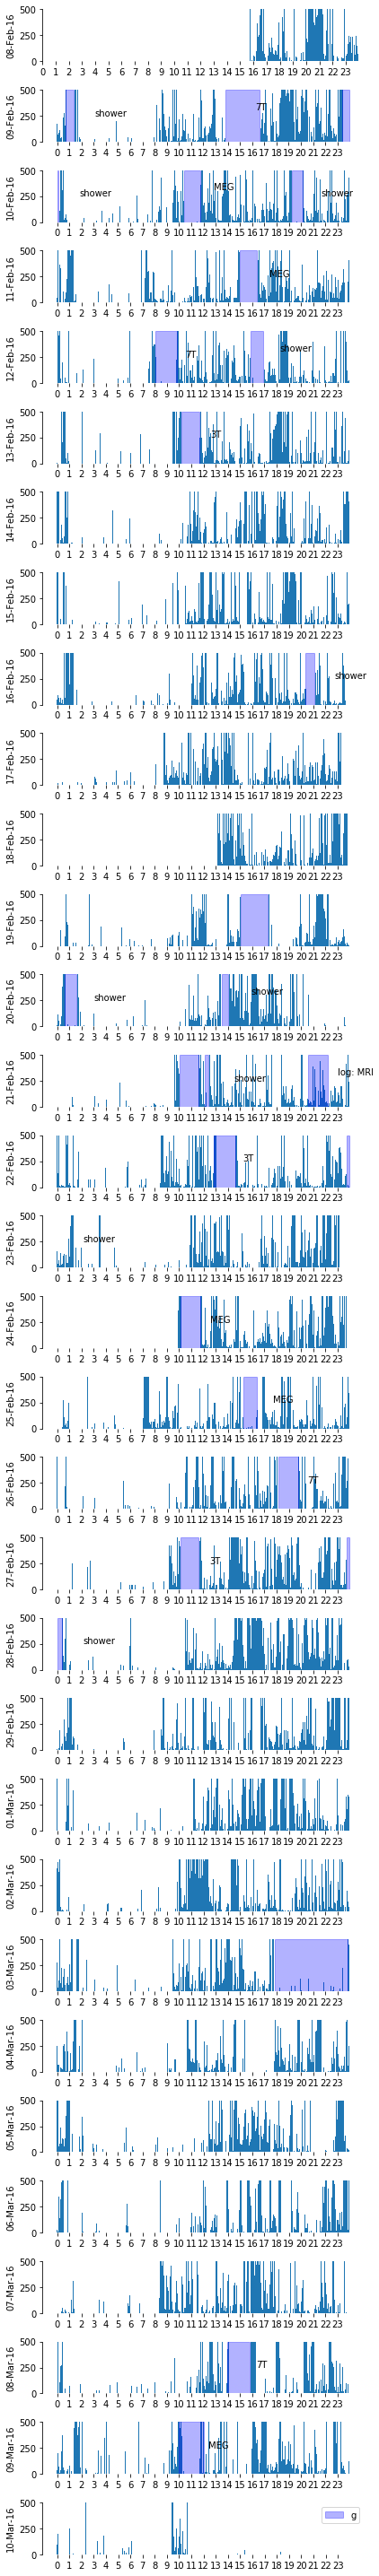

In [255]:
importlib.reload(act)

act.plot_awd(clip_dat,{'g':mk_idx['g']},max_act=500,show=False,comments=gc,fn_pref=os.path.join(out_dir,sub+'_M+edits'),plot_type='single',debug=True)


In [ ]:
importlib.reload(act)

act.plot_awd(clip_dat,{'cal':mk_idx['cal']},max_act=250,show=False,comments=gc,fn_pref=os.path.join(out_dir,sub+'_M+logs_zoom'),plot_type='single',debug=True)
